<a href="https://colab.research.google.com/github/Lzino/bitcoin_prediction_web_prototype/blob/master/BitCoin_prediction_prototype_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: cp949 -*-
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import backend as K
import keras
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Dropout
from tqdm.notebook import tqdm

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path1 = '/content/drive/My Drive/Colab Notebooks/'

In [4]:
df = pd.read_csv(path1 + "btc.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,16/7/2010,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,17/7/2010,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,18/7/2010,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,19/7/2010,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,20/7/2010,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [5]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
scaler = MinMaxScaler(feature_range= (-1,1))
closing_data = df["Close"].values
np.isnan(closing_data)

array([False, False, False, ..., False, False, False])

In [7]:
closing_data2 = closing_data.reshape(-1,1)
scaler.fit(closing_data2)
X_scaled = scaler.transform(closing_data2)
np.mean(X_scaled), np.std(X_scaled)

(-0.8310532907710332, 0.30623932430083745)

In [8]:
df_t = pd.DataFrame(X_scaled, columns=['Close_n'])

In [9]:
df_t.head()

,Close_n
0,-1.000000
1,-0.999996
2,-0.999997
3,-0.999997
4,-0.999997


In [10]:
df_n = df_t.join(df, how = 'outer')

In [11]:
df_n.head()

,Close_n,Date,Open,High,Low,Close,Adj Close,Volume
0,-1.000000,16/7/2010,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,-0.999996,17/7/2010,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,-0.999997,18/7/2010,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,-0.999997,19/7/2010,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,-0.999997,20/7/2010,0.07474,0.07921,0.06634,0.07921,0.07921,42


Plot to see how the bitcoin close price trended over the given time period (July 2010 to April 2019) in days.

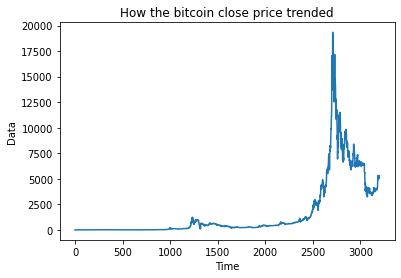

In [12]:
df_n['Close'].plot()
plt.title("How the bitcoin close price trended")
plt.xlabel("Time")
plt.ylabel("Data")
plt.show()

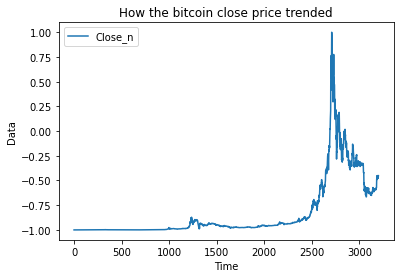

In [13]:
#result of noramlized
df_t.plot()
plt.title("How the bitcoin close price trended")
plt.xlabel("Time")
plt.ylabel("Data")
plt.show()

In [14]:
def window_data(data, window_size):
  X = []
  y = []

  i = 0
  while(i + window_size) <= len(data) -1:
    X.append(data[i:i+window_size])
    y.append(data[i+window_size])

    i += 1
  assert len(X) == len(y)
  return X,y

In [15]:
X, y = window_data(df_n['Close_n'], 7)
X = np.array(X)
y = np.array(y)

X[0].reshape(-1, 7, 1)

array([[[-1.        ],
        [-0.99999624],
        [-0.99999677],
        [-0.99999739],
        [-0.99999693],
        [-0.9999999 ],
        [-0.99999864]]])

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state= 33, shuffle = False)

In [17]:
X_train= X_train.reshape(-1, 7, 1)
X_test = X_test.reshape(-1, 7, 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2874, 7, 1)
(320, 7, 1)
(2874,)
(320,)


In [18]:
def root_mean_squared_error(y_true, y_pred):
  return np.sqrt(np.mean((y_pred-y_true)**2))

## Modeling


In [19]:
def graph_show(hist_input):
  fig, loss_ax = plt.subplots()
  acc_ax = loss_ax.twinx()

  loss_ax.plot(hist_input.history['loss'], 'y', label='train loss')
  loss_ax.set_xlabel('epoch')
  loss_ax.set_ylabel('loss')
  loss_ax.legend(loc='upper left')
  acc_ax.legend(loc='lower left')

  plt.show()

def predict_show(Actual, Prediction):
  plt.figure(figsize=(25, 20))
  plt.subplot(312)
  plt.plot(Actual)
  plt.plot(Prediction)
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Train : Prediction vs Actual' )
  plt.legend(['Actual','Predicted'])

def predict_show_f(Actual, Prediction):
  plt.figure(figsize=(25, 20))
  plt.subplot(312)
  plt.plot(Actual)
  plt.plot(Prediction)
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title('Future(Test) : Prediction vs Actual' )
  plt.legend(['Actual','Predicted'])

In [20]:
def LSTM_regressor_hp(num_units, window_size, batch, drop_percent, iter): # hyper parameter tunning
  activation_function = 'tanh'
  optimizer = keras.optimizers.RMSprop(lr=0.001)
  loss_function = 'mean_squared_error'
  batch_size = batch
  num_epochs = 100
  dropout = drop_percent

  # Initialize the RNN
  regressor = Sequential()

  # Adding the input layer and the LSTM layer
  regressor.add(LSTM(num_units, return_sequences = False, activation = activation_function, input_shape = (window_size, 1)))
  regressor.add(Dropout(dropout))

  # Adding the output layer
  regressor.add(Dense(units = 1))

  # Compiling the RNN
  regressor.compile(optimizer = optimizer, loss = loss_function, metrics= ['accuracy'])

  # Using the training set to train the model
  hist = regressor.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, verbose= 1,
                validation_data=(X_test, y_test))
  
  prediction = regressor.predict(X_train)
  prediction_f = regressor.predict(X_test)
  
  print( '(d) RMSE Testing Score: ', root_mean_squared_error(y_test, prediction_f))

  graph_show(hist)
  predict_show(y_train,prediction)
  predict_show_f(y_test,prediction_f)
  plt.savefig(path1 + f'graph{iter}.png', dpi=300)

Train on 2874 samples, validate on 320 samples
Epoch 1/100
2874/2874 [==============================] - 2s 587us/step - loss: 0.1846 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 2/100
2874/2874 [==============================] - 1s 367us/step - loss: 0.0053 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 3/100
2874/2874 [==============================] - 1s 370us/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 4/100
2874/2874 [==============================] - 1s 356us/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 5/100
2874/2874 [==============================] - 1s 378us/step - loss: 0.0019 - accuracy: 3.4795e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 6/100
2874/2874 [==============================] - 1s 363us/step - loss: 0.0018 - accuracy: 3.4795e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 7/100
2874/2874 [

No handles with labels found to put in legend.


(d) RMSE Testing Score:  0.20978187557770303


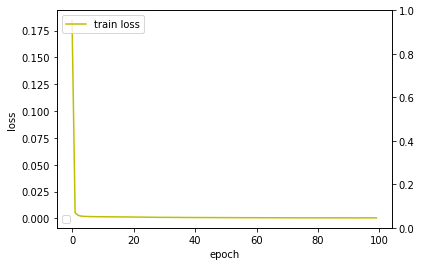

Train on 2874 samples, validate on 320 samples
Epoch 1/100
2874/2874 [==============================] - 1s 514us/step - loss: 0.0964 - accuracy: 0.0000e+00 - val_loss: 0.0071 - val_accuracy: 0.0000e+00
Epoch 2/100
2874/2874 [==============================] - 1s 388us/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 3/100
2874/2874 [==============================] - 1s 390us/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 4/100
2874/2874 [==============================] - 1s 367us/step - loss: 0.0027 - accuracy: 3.4795e-04 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 5/100
2874/2874 [==============================] - 1s 368us/step - loss: 0.0025 - accuracy: 3.4795e-04 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 6/100
2874/2874 [==============================] - 1s 375us/step - loss: 0.0024 - accuracy: 3.4795e-04 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 7/100
2874/2874 [

No handles with labels found to put in legend.


(d) RMSE Testing Score:  0.21063547725249163


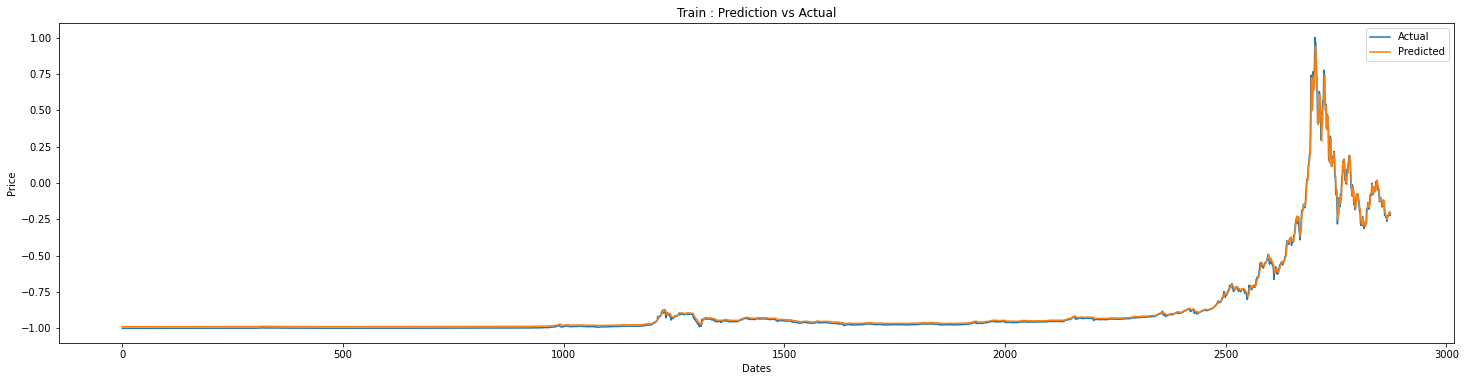

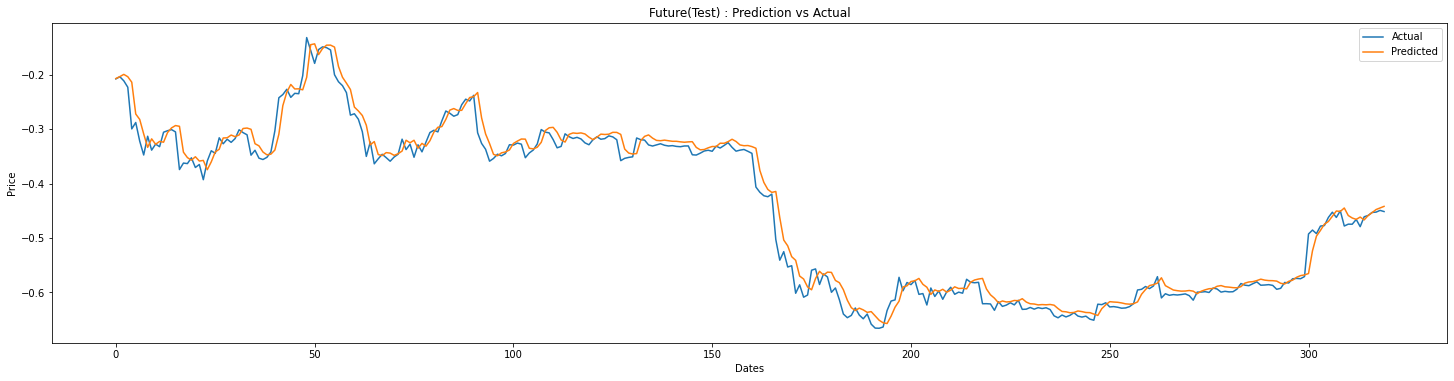

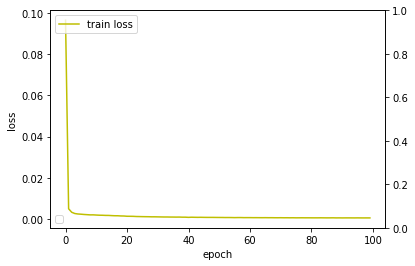

Train on 2874 samples, validate on 320 samples
Epoch 1/100
2874/2874 [==============================] - 1s 490us/step - loss: 0.0603 - accuracy: 0.0000e+00 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 2/100
2874/2874 [==============================] - 1s 380us/step - loss: 0.0063 - accuracy: 0.0000e+00 - val_loss: 0.0027 - val_accuracy: 0.0000e+00
Epoch 3/100
2874/2874 [==============================] - 1s 386us/step - loss: 0.0050 - accuracy: 3.4795e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 4/100
2874/2874 [==============================] - 1s 374us/step - loss: 0.0045 - accuracy: 3.4795e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 5/100
2874/2874 [==============================] - 1s 363us/step - loss: 0.0040 - accuracy: 3.4795e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/100
2874/2874 [==============================] - 1s 375us/step - loss: 0.0036 - accuracy: 3.4795e-04 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 7/100
2874/2874 [

No handles with labels found to put in legend.


(d) RMSE Testing Score:  0.20938776715569213


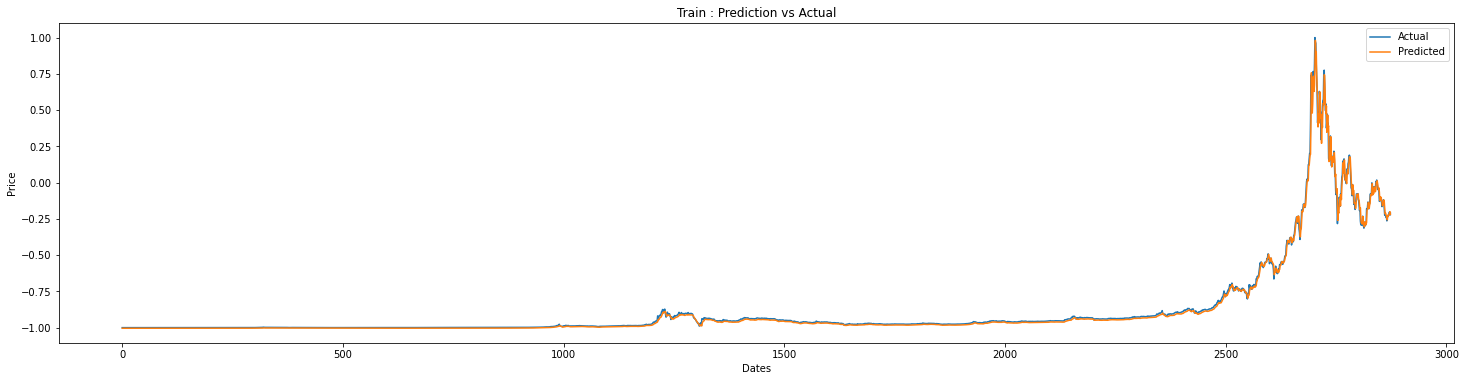

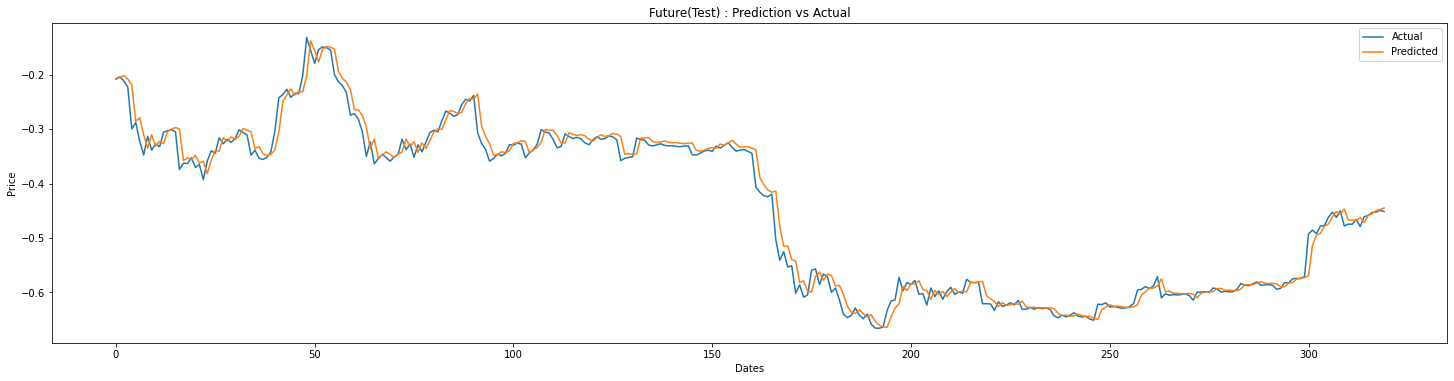

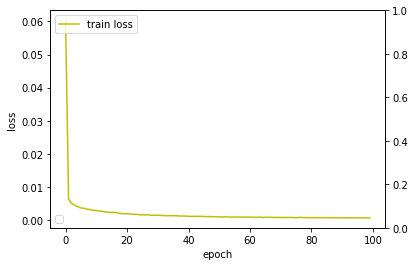

Train on 2874 samples, validate on 320 samples
Epoch 1/100
2874/2874 [==============================] - 2s 535us/step - loss: 0.0348 - accuracy: 0.0000e+00 - val_loss: 0.0049 - val_accuracy: 0.0000e+00
Epoch 2/100
2874/2874 [==============================] - 1s 407us/step - loss: 0.0084 - accuracy: 3.4795e-04 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 3/100
2874/2874 [==============================] - 1s 407us/step - loss: 0.0073 - accuracy: 3.4795e-04 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 4/100
2874/2874 [==============================] - 1s 410us/step - loss: 0.0063 - accuracy: 3.4795e-04 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 5/100
2874/2874 [==============================] - 1s 402us/step - loss: 0.0057 - accuracy: 3.4795e-04 - val_loss: 0.0047 - val_accuracy: 0.0000e+00
Epoch 6/100
2874/2874 [==============================] - 1s 405us/step - loss: 0.0052 - accuracy: 3.4795e-04 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 7/100
2874/2874 [

No handles with labels found to put in legend.


(d) RMSE Testing Score:  0.20888999819318024


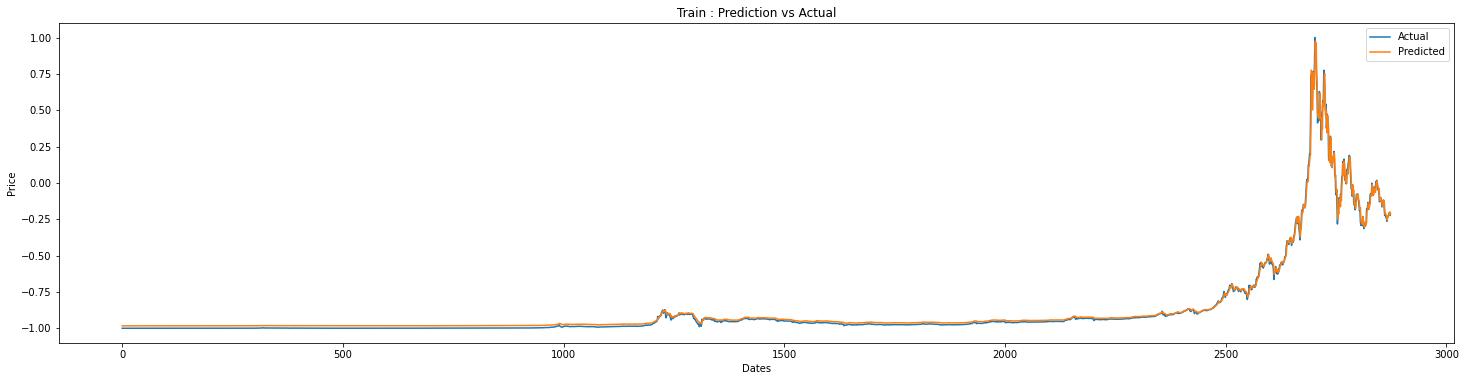

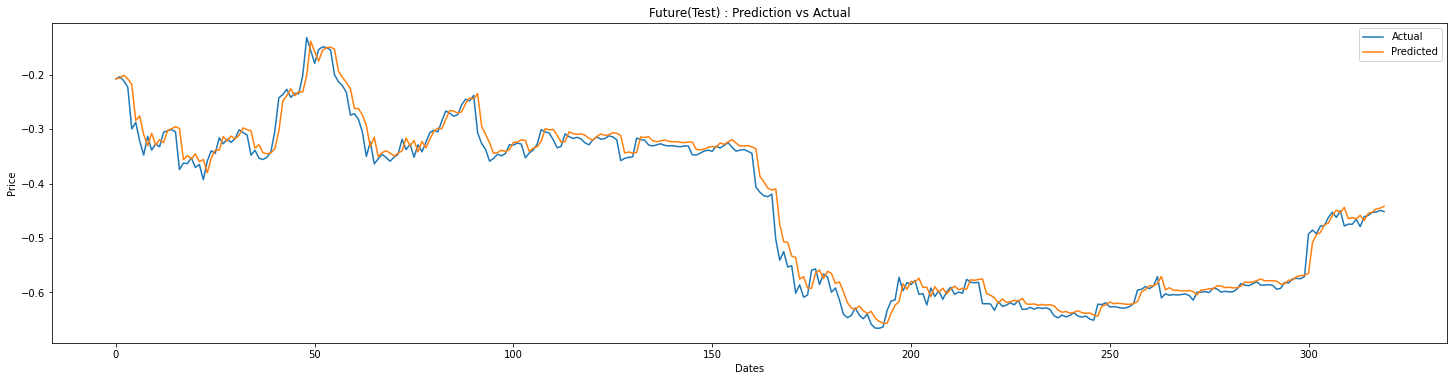

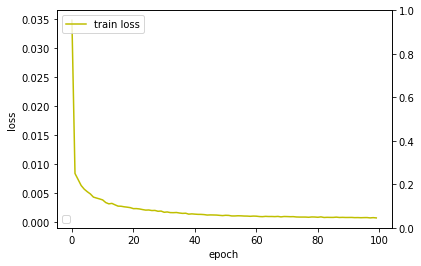

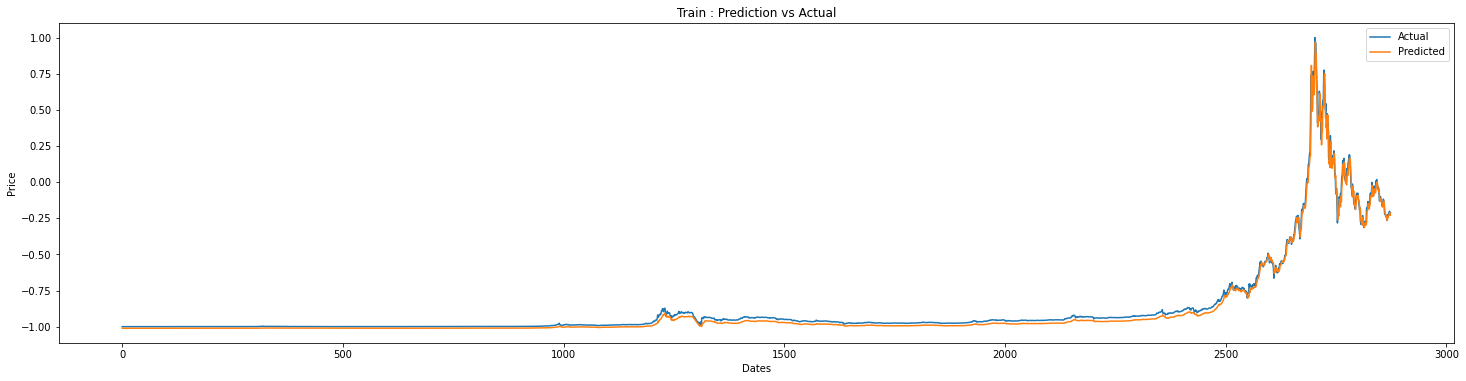

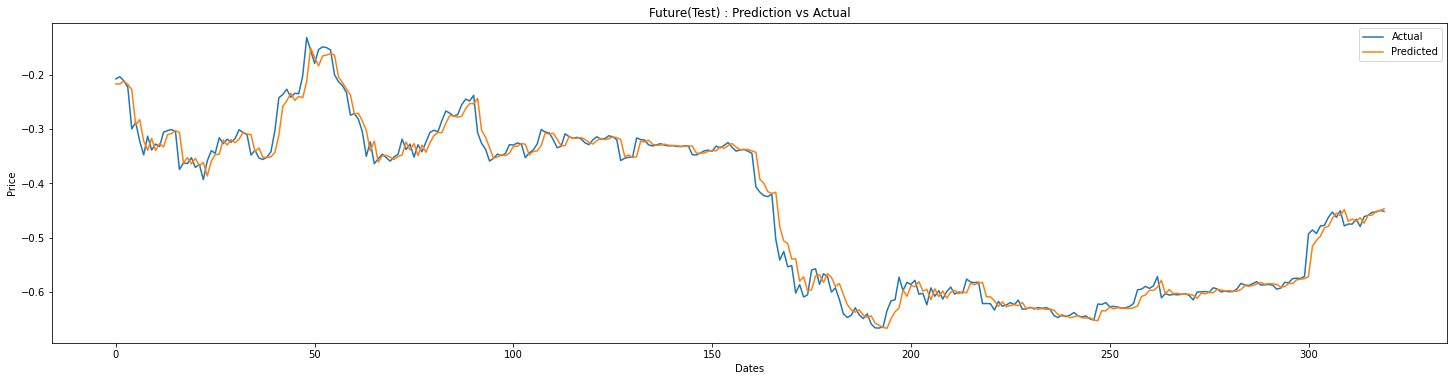

In [21]:
# num_units = 5, window_size = 7
num_list = [32,64,128,256] #
for i , v in tqdm(enumerate(num_list)) :
  LSTM_regressor_hp(v, 7, 64, 0, i)